In [ ]:
import torch
import torchvision as tv
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable
from torch.utils.data import DataLoader,random_split
from torchvision.utils import save_image
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from numpy import arange
from tqdm import tqdm as tqdm_regular
from google.colab import files
import torchvision
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import plotly.express as px
import pandas as pd

## Used that dataloader

In [ ]:
# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# load the training and test datasets
train_dataset  = tv.datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = tv.datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create training and test dataloaders

num_workers = 2

100%|██████████| 9912422/9912422 [00:00<00:00, 75225239.86it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 117152508.53it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 32987795.83it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 22049223.11it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform
# Set the test transform
test_dataset.transform = test_transform
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

In [ ]:
class Encoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            # First convolutional layer
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            #nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Second convolutional layer
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Third convolutional layer
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            #nn.BatchNorm2d(32),
            nn.ReLU(True)
        )

        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)

        ### Linear section
        self.encoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, encoded_space_dim)
        )

    def forward(self, x):
        # Apply convolutions
        x = self.encoder_cnn(x)
        # Flatten
        x = self.flatten(x)
        # # Apply linear layers
        x = self.encoder_lin(x)
        return x

In [ ]:
class Decoder(nn.Module):

    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self, latent_dims, input_dim):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, input_dim)
        self.decoder = Decoder(latent_dims, input_dim)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

In [ ]:
# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')
d = 3

model = Autoencoder(d, input_dim=128)
if torch.cuda.is_available():
    model.cuda()
lr= 0.001
def train_network(model, num_epochs, lr, plot_outputs = True, is_vae=False):
  loss_fn = torch.nn.MSELoss()
  if is_vae:
    loss_fn = model.vae_loss
  optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
  #optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

  #TODO make it dependet on input variable
  num_epochs = 10
  history={'train_loss':[],'val_loss':[]}
  for epoch in range(num_epochs):

    train_loss = train_epoch(model,device,train_loader,loss_fn,optim)
    val_loss = test_epoch(model,device,valid_loader,loss_fn)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if plot_outputs:
      plot_ae_outputs(model,n=5)

  return history


Selected device: cuda


In [ ]:
### Training function
def train_epoch(model, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        decoded_data = model(image_batch)

        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
def test_epoch(model, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            decoded_data = model(image_batch)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
def plot_ae_outputs(model,n=5):
    plt.figure(figsize=(10,4.5))
    for i in range(n):
      ax = plt.subplot(2,n,i+1)
      img = test_dataset[i][0].unsqueeze(0).to(device)
      model.eval()
      with torch.no_grad():
         rec_img  = model(img)
      plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
        ax.set_title('Original images')
      ax = plt.subplot(2, n, i + 1 + n)
      plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)
      if i == n//2:
         ax.set_title('Reconstructed images')
    plt.show()

In [ ]:
history=train_network(model, 5, lr, False, False)


 EPOCH 1/10 	 train loss 0.132 	 val loss 0.074

 EPOCH 2/10 	 train loss 0.058 	 val loss 0.047

 EPOCH 3/10 	 train loss 0.043 	 val loss 0.039

 EPOCH 4/10 	 train loss 0.038 	 val loss 0.037

 EPOCH 5/10 	 train loss 0.036 	 val loss 0.036

 EPOCH 6/10 	 train loss 0.035 	 val loss 0.035

 EPOCH 7/10 	 train loss 0.034 	 val loss 0.034

 EPOCH 8/10 	 train loss 0.034 	 val loss 0.034

 EPOCH 9/10 	 train loss 0.033 	 val loss 0.033

 EPOCH 10/10 	 train loss 0.033 	 val loss 0.033


TypeError: ignored

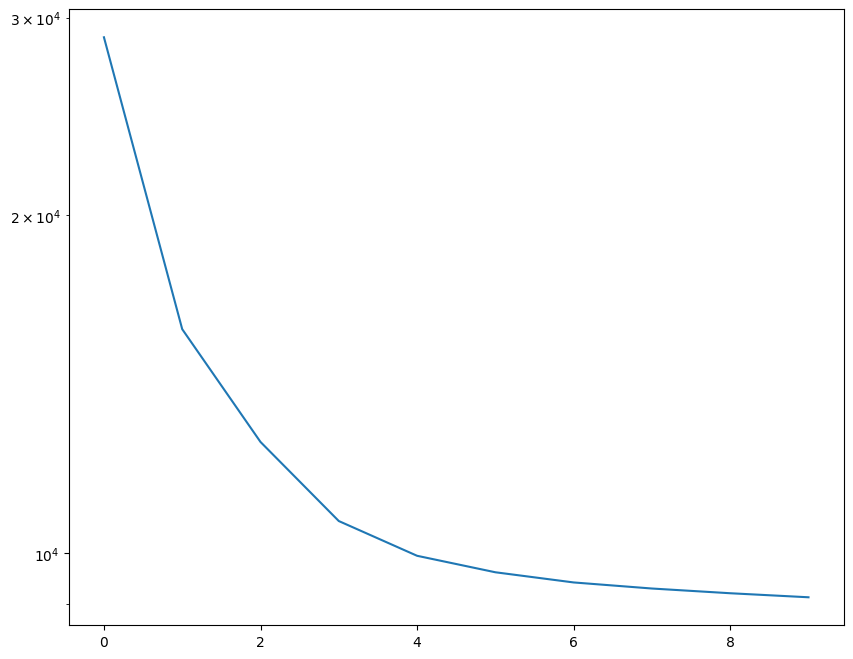

In [ ]:
def plot_losses(history):
  plt.figure(figsize=(10, 8))

  # Plotting the training loss (assuming 'train_loss' is a list/tensor)
  train_loss = history['train_loss']
  if isinstance(train_loss, torch.Tensor):
      train_loss = train_loss.cpu().detach().numpy()
  plt.semilogy(train_loss, label='Train')

  # Plotting the validation loss (assuming 'val_loss' is a list/tensor)
  val_loss = history['val_loss']
  if isinstance(val_loss, torch.Tensor):
      val_loss = val_loss.cpu().detach().numpy()
  plt.semilogy(val_loss, label='Valid')

  plt.xlabel('Epoch')
  plt.ylabel('Average Loss')
  plt.legend()
  plt.show()


plot_losses(history)

In [ ]:
def plot_latent(model,test_dataset):
  encoded_samples = []
  for sample in tqdm(test_dataset):
      img = sample[0].unsqueeze(0).to(device)
      label = sample[1]
      # Encode image
      model.eval()
      with torch.no_grad():
          encoded_img  = model.encoder(img)
      # Append to list
      encoded_img = encoded_img.flatten().cpu().numpy()
      encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
      encoded_sample['label'] = label
      encoded_samples.append(encoded_sample)
  encoded_samples = pd.DataFrame(encoded_samples)
  tsne = TSNE(n_components=2)
  tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
  fig = px.scatter(tsne_results, x=0, y=1, color=encoded_samples.label.astype(str),labels={'0': 'tsne-2d-one', '1': 'tsne-2d-two'})
  fig.show()
  plt.figure(figsize=(17, 9))
  plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10')
  plt.colorbar()
  plt.show()


100%|██████████| 10000/10000 [00:09<00:00, 1072.88it/s]


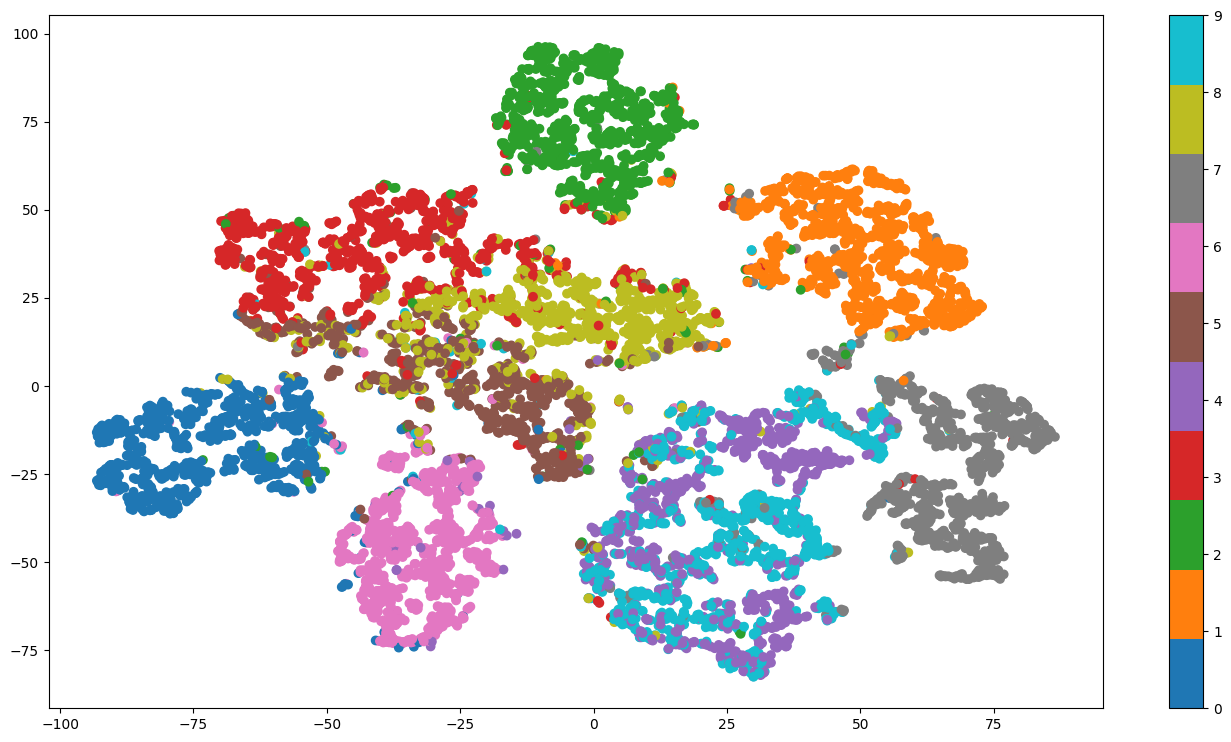

In [ ]:
plot_latent(model, test_dataset)

In [ ]:
def visual_compare(model):
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = next(dataiter)

  print(len(test_loader))
  # get sample outputs
  output = model(images)
  # prep images for display
  images = images.numpy()

  print(output.size())
  # output is resized into a batch of iages
  output = output.view(batch_size, 1, 28, 28)
  # use detach when it's an output that requires_grad
  output_on_cpu = output.cpu()
  output = output_on_cpu.detach().numpy()

  # plot the first ten input images and then reconstructed images
  fig, axes = plt.subplots(nrows=2, ncols=20, sharex=True, sharey=True, figsize=(50,4))

  # input images on top row, reconstructions on bottom
  for images, row in zip([images, output], axes):
      for img, ax in zip(images, row):
          ax.imshow(np.squeeze(img), cmap='gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

visual_compare(model)

# VAE
https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/VAE_mnist.ipynb

In [ ]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        #self.drop1=nn.Dropout2d(p=0.3)
        # 6 * 6 * 16 = 576
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [ ]:
class VariationalDecoder(nn.Module):

    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )

    def forward(self, x):
        # Apply linear layers
        x = self.decoder_lin(x)
        # Unflatten
        x = self.unflatten(x)
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = VariationalDecoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

    def vae_loss(self, x, x_hat):
      return ((x - x_hat)**2).sum() + self.encoder.kl

In [ ]:
model = VariationalAutoencoder(d)
if torch.cuda.is_available():
    model.cuda()

history=train_network(model, 5, lr, False, True)


 EPOCH 1/10 	 train loss 28819.994 	 val loss 866220.375

 EPOCH 2/10 	 train loss 15830.697 	 val loss 596032.625

 EPOCH 3/10 	 train loss 12560.015 	 val loss 476295.125

 EPOCH 4/10 	 train loss 10678.247 	 val loss 408557.750

 EPOCH 5/10 	 train loss 9943.440 	 val loss 386047.344

 EPOCH 6/10 	 train loss 9612.621 	 val loss 367250.344

 EPOCH 7/10 	 train loss 9413.961 	 val loss 362643.094

 EPOCH 8/10 	 train loss 9297.343 	 val loss 356312.281

 EPOCH 9/10 	 train loss 9207.701 	 val loss 350125.250

 EPOCH 10/10 	 train loss 9131.709 	 val loss 348048.375


TypeError: ignored

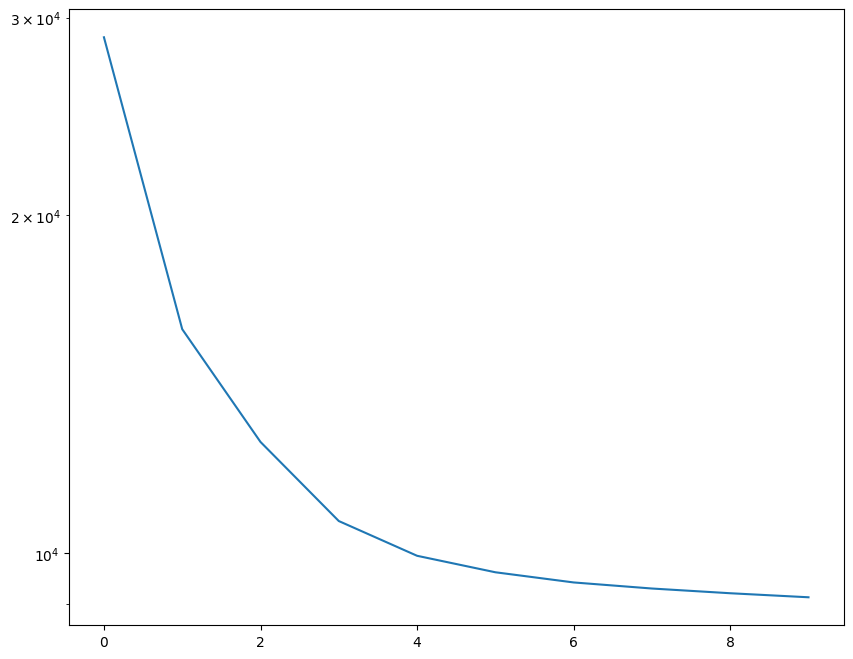

In [ ]:
plot_losses(history)

100%|██████████| 10000/10000 [00:13<00:00, 746.32it/s]


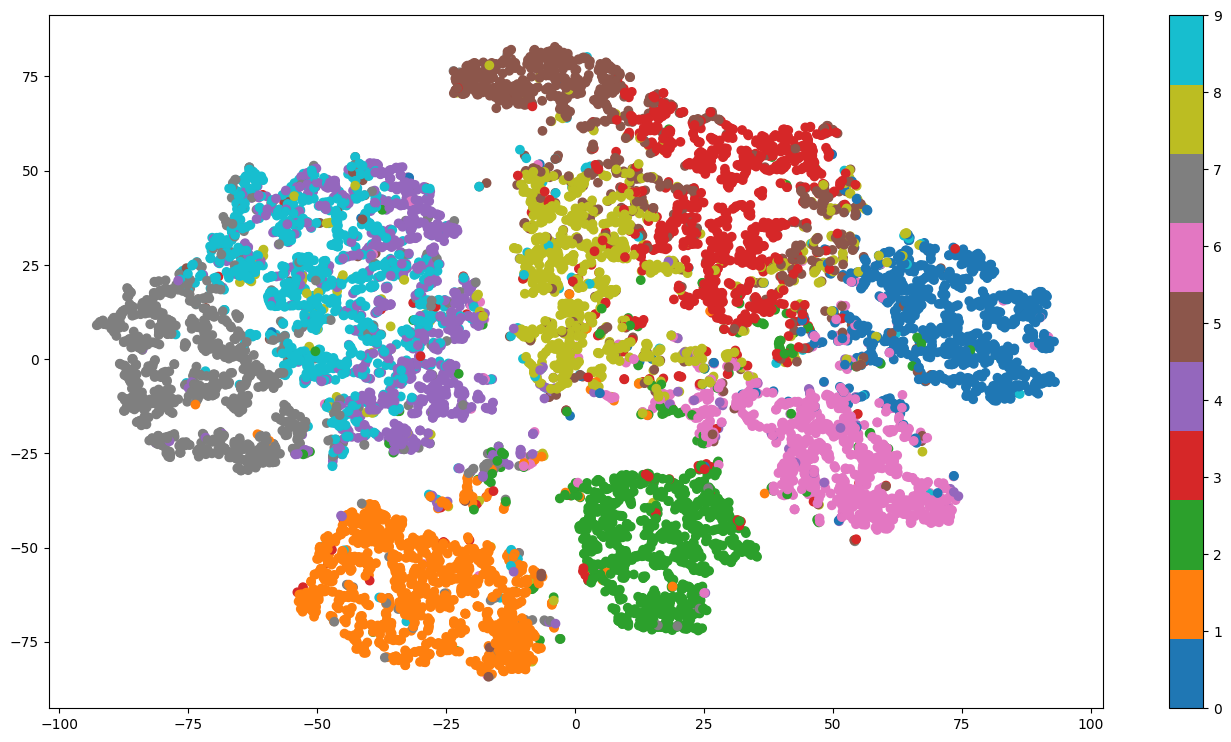

In [ ]:
plot_latent(model, test_dataset)

40
torch.Size([256, 1, 28, 28])


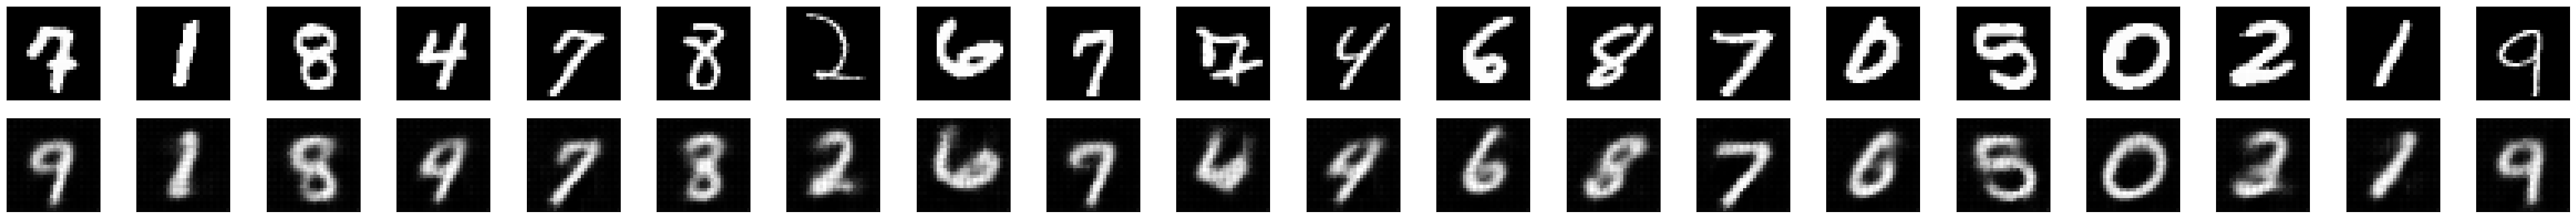

In [ ]:
visual_compare(model)

# Denoising AE

In [ ]:
model = Autoencoder(d, input_dim=128)
if torch.cuda.is_available():
    model.cuda()

In [ ]:
def train_network_noise(model, num_epochs, lr, plot_outputs = True, is_vae=False):
  loss_fn = torch.nn.MSELoss()
  if is_vae:
    loss_fn = model.vae_loss
  optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-05)
  #optim = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=6e-05)

  #TODO make it dependet on input variable
  noise_factor = 0.5
  num_epochs = 10
  history={'train_loss':[],'val_loss':[]}
  for epoch in range(num_epochs):

    train_loss = train_epoch_noise(model,device,train_loader,loss_fn,optim, noise_factor)
    val_loss = test_epoch_noise(model,device,valid_loader,loss_fn, noise_factor)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    if plot_outputs:
      plot_ae_outputs(model,n=5)

  return history


In [ ]:
### Training function
def train_epoch_noise(model, device, dataloader, loss_fn, optimizer, noise_factor):
    # Set train mode for both the encoder and the decoder
    model.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        ## add random noise to the input images
        noisy_imgs = image_batch + noise_factor * torch.randn(*image_batch.shape)
        # Clip the images to be between 0 and 1
        noisy_imgs = np.clip(noisy_imgs, 0., 1.)

        # Move tensor to the proper device
        noisy_imgs = noisy_imgs.to(device)
        # Encode data
        decoded_data = model(noisy_imgs)
        image_batch = image_batch.to(device)

        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [ ]:
def test_epoch_noise(model, device, dataloader, loss_fn, noise_factor):
    # Set evaluation mode for encoder and decoder
    model.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            ## add random noise to the input images
            noisy_imgs = image_batch + noise_factor * torch.randn(*image_batch.shape)
            # Clip the images to be between 0 and 1
            noisy_imgs = np.clip(noisy_imgs, 0., 1.)

            # Move tensor to the proper device
            #noisy_imgs = noisy_imgs.to(device)
            decoded_data = model(noisy_imgs)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label)
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [ ]:
history=train_network_noise(model, 5, lr, False, False)


 EPOCH 1/10 	 train loss 0.042 	 val loss 0.040

 EPOCH 2/10 	 train loss 0.039 	 val loss 0.038

 EPOCH 3/10 	 train loss 0.038 	 val loss 0.037

 EPOCH 4/10 	 train loss 0.037 	 val loss 0.037

 EPOCH 5/10 	 train loss 0.036 	 val loss 0.036

 EPOCH 6/10 	 train loss 0.036 	 val loss 0.036

 EPOCH 7/10 	 train loss 0.035 	 val loss 0.035

 EPOCH 8/10 	 train loss 0.035 	 val loss 0.035

 EPOCH 9/10 	 train loss 0.035 	 val loss 0.035

 EPOCH 10/10 	 train loss 0.035 	 val loss 0.035


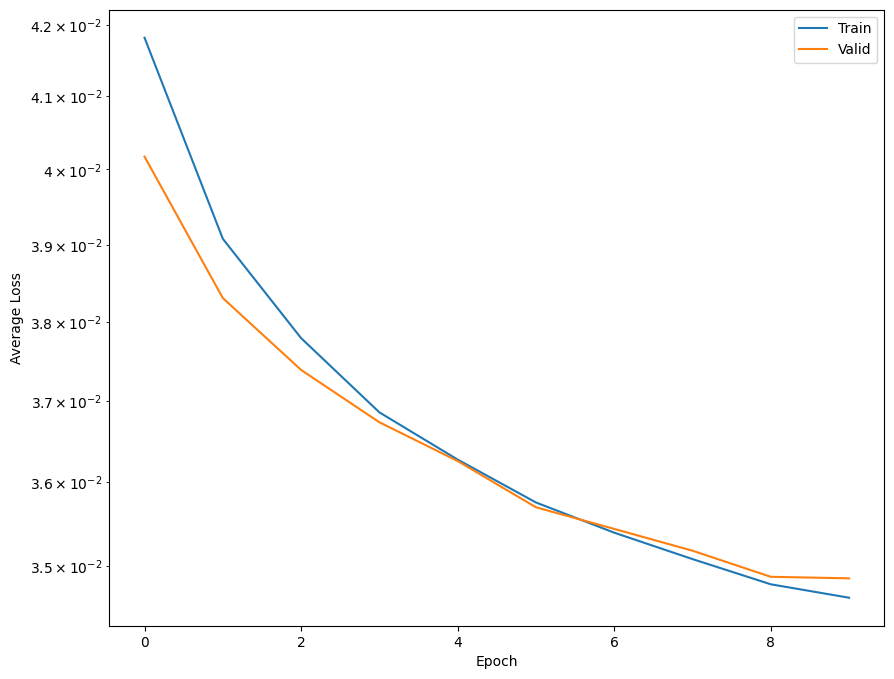

In [ ]:
plot_losses(history)

100%|██████████| 10000/10000 [00:09<00:00, 1097.06it/s]


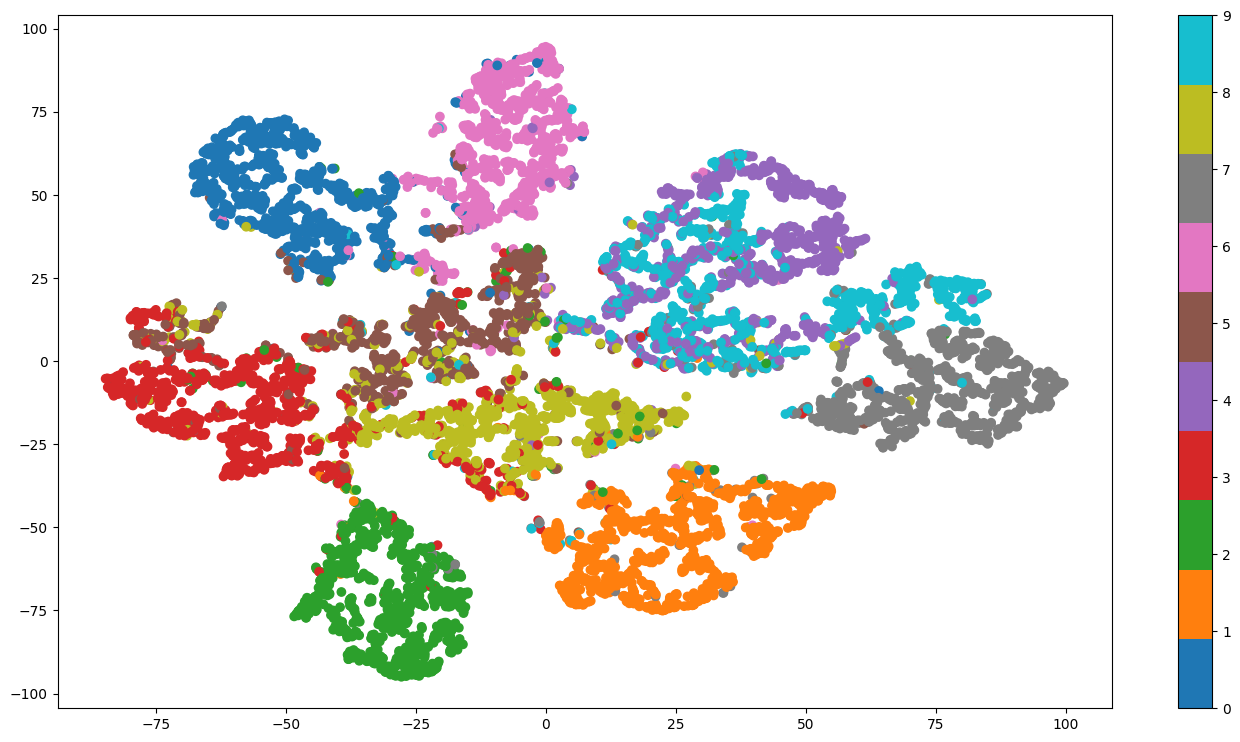

In [ ]:
plot_latent(model, test_dataset)

40
torch.Size([256, 1, 28, 28])


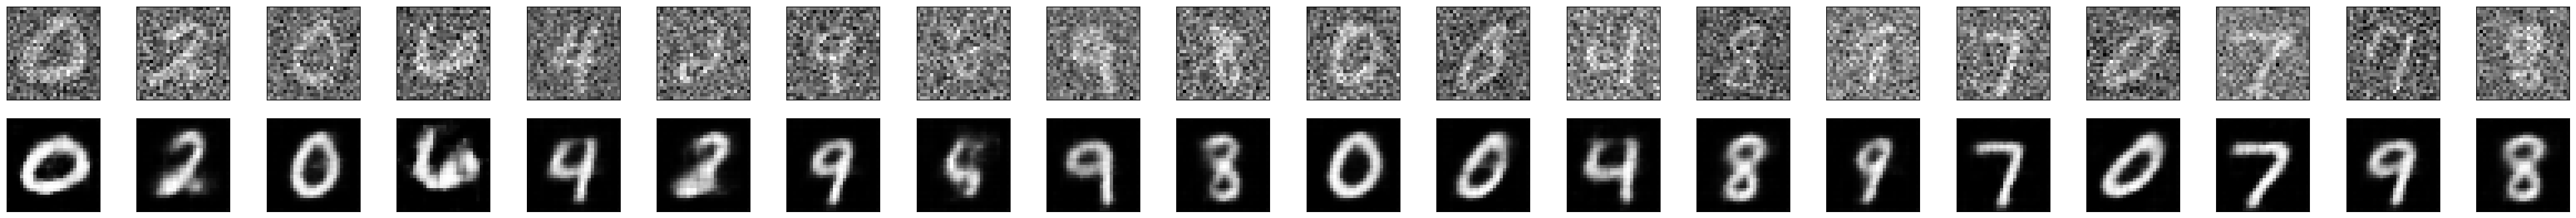

In [ ]:
def visual_compare_noise(model, noise_factor=0.5):
  # obtain one batch of test images
  dataiter = iter(test_loader)
  images, labels = next(dataiter)
  noisy_imgs = images + noise_factor * torch.randn(*images.shape)
  print(len(test_loader))
  # get sample outputs
  output = model(noisy_imgs)
  # prep images for display
  noisy_imgs = noisy_imgs.numpy()

  print(output.size())
  # output is resized into a batch of iages
  output = output.view(batch_size, 1, 28, 28)
  # use detach when it's an output that requires_grad
  output_on_cpu = output.cpu()
  output = output_on_cpu.detach().numpy()

  # plot the first ten input images and then reconstructed images
  fig, axes = plt.subplots(nrows=2, ncols=20, sharex=True, sharey=True, figsize=(50,4))

  # input images on top row, reconstructions on bottom
  for images, row in zip([noisy_imgs, output], axes):
      for img, ax in zip(images, row):
          ax.imshow(np.squeeze(img), cmap='gray')
          ax.get_xaxis().set_visible(False)
          ax.get_yaxis().set_visible(False)

visual_compare_noise(model, 0.5)

#Further Links

## Denoising

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/autoencoder/denoising-autoencoder/Denoising_Autoencoder_Solution.ipynb

## Variational

https://github.com/ac-alpha/VAEs-using-Pytorch

https://github.com/debtanu177/CVAE_MNIST


## PART two


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
%cd gdrive/MyDrive/yolo/

/content/gdrive/MyDrive/yolo


In [ ]:
!git clone https://github.com/ultralytics/yolov5 # clone repo
%cd yolov5
%pip install -qr requirements.txt # install dependencies

Cloning into 'yolov5'...
remote: Enumerating objects: 16074, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 16074 (delta 5), reused 9 (delta 1), pack-reused 16056
Receiving objects: 100% (16074/16074), 14.63 MiB | 14.05 MiB/s, done.
Resolving deltas: 100% (11037/11037), done.
/content/gdrive/MyDrive/yolo/yolov5


In [ ]:
%%writefile DATASETFILE.yaml

train: ../KITTI_dataset/train # folder contains images and labels subfolders
val: ../KITTI_dataset/test # folder contains images and labels subfolders
nc: 1
names: [Vehicles]

Writing DATASETFILE.yaml


In [ ]:
!python train.py --img 416 --batch 16 --epochs 50 --data DATASETFILE.yaml --weights '' --cfg yolov5s.yaml --cache

2023-11-22 12:14:33.135363: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 12:14:33.135419: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 12:14:33.135455: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=, cfg=yolov5s.yaml, data=DATASETFILE.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, pr

In [ ]:
!python train.py --img 416 --batch 16 --epochs 50 --data DATASETFILE.yaml --weights yolov5s.pt --cache

2023-11-22 12:20:55.708550: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-22 12:20:55.708608: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-22 12:20:55.708646: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
train: weights=yolov5s.pt, cfg=, data=DATASETFILE.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, proj